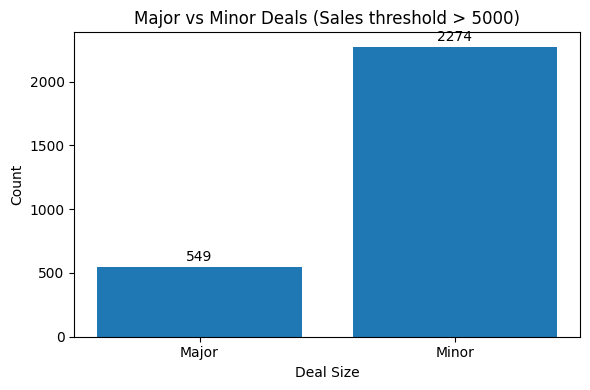

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- THE FIX IS HERE ---
# Add line to load the df DataFrame.
# Use the correct path and encoding found in previous successful executions.
df = pd.read_csv('/content/sample_data/sample_sales_data.csv', encoding='latin1')
# -----------------------

# --- Create Deal_Size column (defensive) ---
# Ensure SALES is numeric (coerce invalid -> NaN)
df['SALES'] = pd.to_numeric(df['SALES'], errors='coerce')

# Label Major if > 5000, Minor otherwise (NaN -> keep as NaN or treat as 'Minor' if you prefer)
df['Deal_Size'] = df['SALES'].apply(lambda x: 'Major' if pd.notna(x) and x > 5000 else 'Minor')

# --- Count Major vs Minor ---
counts = df['Deal_Size'].value_counts().reindex(['Major', 'Minor'], fill_value=0)

# --- Plot ---
fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(counts.index, counts.values)
ax.set_title("Major vs Minor Deals (Sales threshold > 5000)")
ax.set_xlabel("Deal Size")
ax.set_ylabel("Count")

# add value labels above bars
for bar in bars:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + max(counts.values)*0.01, f'{int(h)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Trend model: slope (per day) = 10.1776, intercept = 6981.92


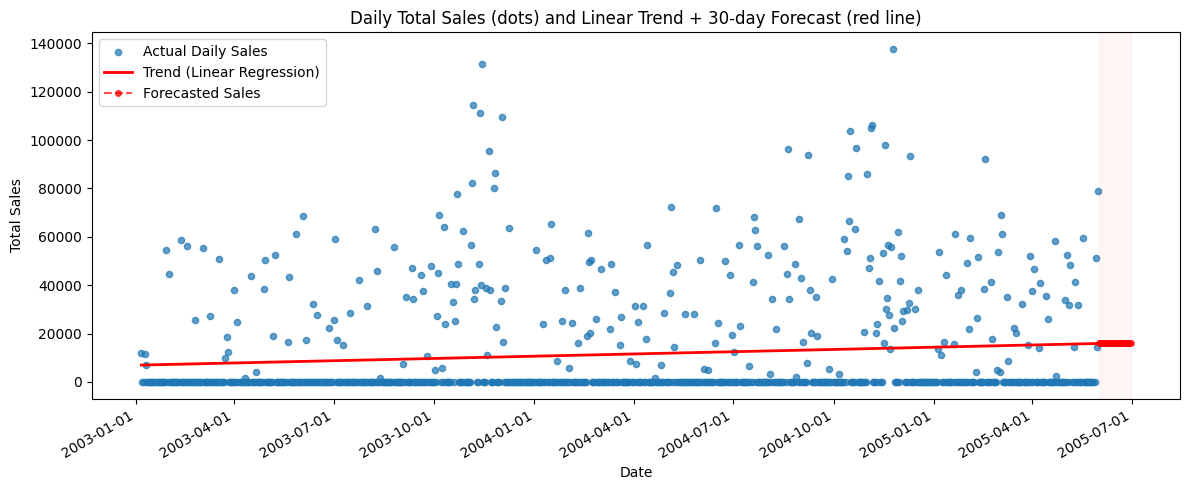


Next 30 days forecast (first 10 rows):
      DATE  Forecasted_Total_Sales
2005-06-01            15907.687479
2005-06-02            15917.865096
2005-06-03            15928.042713
2005-06-04            15938.220330
2005-06-05            15948.397947
2005-06-06            15958.575564
2005-06-07            15968.753181
2005-06-08            15978.930798
2005-06-09            15989.108415
2005-06-10            15999.286032


In [ ]:
# Required libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates

# --- FIX: Ensure df is loaded with relevant columns ---
# Using the user-specified file 'sample_sales_data.csv'
# This assumes the file exists and contains 'SALES' and 'ORDERDATE' columns.
# FIX: Added encoding='latin1' to handle UnicodeDecodeError.
df = pd.read_csv('/content/sample_data/sample_sales_data.csv', encoding='latin1')

# --- Defensive preprocessing ---
# 1) Ensure SALES numeric
df['SALES'] = pd.to_numeric(df['SALES'], errors='coerce')

# 2) Convert ORDERDATE to datetime
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'], errors='coerce')

# Drop rows where ORDERDATE or SALES is invalid (optional)
df = df.dropna(subset=['ORDERDATE', 'SALES'])  # Drop if either is missing

# --- Aggregate to daily totals ---
# Normalize to date only (midnight) then group
df['ORDERDATE_DAY'] = df['ORDERDATE'].dt.normalize()  # midnight of each day
daily = df.groupby('ORDERDATE_DAY', as_index=True)['SALES'].sum().sort_index()

# Reindex to full date range so we have contiguous daily index (fill missing days with 0)
full_index = pd.date_range(start=daily.index.min(), end=daily.index.max(), freq='D')
daily = daily.reindex(full_index, fill_value=0)  # change fill_value if you prefer np.nan

daily.index.name = 'DATE'
daily = daily.rename('Total_Sales').to_frame()

# --- Prepare data for regression ---
# X = days since first date (integer), y = daily totals
daily = daily.reset_index()
daily['day_index'] = (daily['DATE'] - daily['DATE'].min()).dt.days
X = daily['day_index'].values.reshape(-1, 1)    # shape (n_samples, 1)
y = daily['Total_Sales'].values                # shape (n_samples,)

# Fit Linear Regression
model = LinearRegression()
model.fit(X, y)

print(f"Trend model: slope (per day) = {model.coef_[0]:.4f}, intercept = {model.intercept_:.2f}")

# --- Forecast next 30 days ---
n_forecast = 30
last_day_index = daily['day_index'].iloc[-1]
future_day_indices = np.arange(last_day_index + 1, last_day_index + 1 + n_forecast).reshape(-1, 1)

# Create future date range
future_dates = pd.date_range(start=daily['DATE'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast, freq='D')

# Predict
y_pred_hist = model.predict(X)                      # fitted values for history (trend line)
y_pred_future = model.predict(future_day_indices)   # forecasted values for next 30 days

# Combine for plotting trend line across history+future
all_dates = np.concatenate([daily['DATE'].values, future_dates])
all_day_indices = np.concatenate([X.flatten(), future_day_indices.flatten()])
all_preds = model.predict(all_day_indices.reshape(-1,1))

# --- Plot: actual dots and trend line (including forecast) ---
fig, ax = plt.subplots(figsize=(12,5))

# Actual historical daily totals as dots
ax.scatter(daily['DATE'], daily['Total_Sales'], s=20, label='Actual Daily Sales', alpha=0.7)

# Trend line across history + forecast (red line)
ax.plot(all_dates, all_preds, color='red', linewidth=2, label='Trend (Linear Regression)')

# Mark forecast portion (optional: shaded)
ax.axvspan(future_dates[0], future_dates[-1], color='red', alpha=0.04)

# Optionally, plot forecast points explicitly
ax.plot(future_dates, y_pred_future, color='red', linestyle='--', marker='o', markersize=4, alpha=0.7, label='Forecasted Sales')

# Formatting X axis as dates
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=30, ha='right')

ax.set_title('Daily Total Sales (dots) and Linear Trend + 30-day Forecast (red line)')
ax.set_xlabel('Date')
ax.set_ylabel('Total Sales')
ax.legend()
plt.tight_layout()
plt.show()

# --- Optional: show forecast table ---
forecast_df = pd.DataFrame({
    'DATE': future_dates,
    'Forecasted_Total_Sales': y_pred_future
})
print("\nNext 30 days forecast (first 10 rows):")
print(forecast_df.head(10).to_string(index=False))

In [ ]:
import pandas as pd
import numpy as np

# 1. Setup Data
# FIX: Corrected file path and added encoding
ledger = pd.read_csv('/content/sample_data/sample_sales_data.csv', encoding='latin1')

# 2. Simulate Bank Statement (Drop 5 random rows)
np.random.seed(42)
missing_indices = np.random.choice(ledger.index, 5, replace=False)
bank_statement = ledger.drop(missing_indices)

print(f"Internal Ledger: {len(ledger)} rows")
print(f"Bank Statement:  {len(bank_statement)} rows")
print("Running Strict Reconciliation...\n")

# --- THE FIX ---
# We match on MULTIPLE columns to ensure uniqueness
# We act like a Composite Key: Order + Quantity + Price + Sales
match_columns = ['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'SALES']

reconciliation = pd.merge(
    ledger,
    bank_statement,
    on=match_columns,
    how='left',
    indicator=True
)

# 4. Filter for Mismatches
missing_items = reconciliation[reconciliation['_merge'] == 'left_only']

# 5. Output
print(f"⚠️ DISCREPANCY FOUND: {len(missing_items)} transactions are missing!\n")
print(missing_items[match_columns])

Internal Ledger: 2823 rows
Bank Statement:  2818 rows
Running Strict Reconciliation...

⚠️ DISCREPANCY FOUND: 5 transactions are missing!

      ORDERNUMBER  QUANTITYORDERED  PRICEEACH    SALES
1091        10122               21      73.17  1536.57
1105        10287               43      70.76  3042.68
1437        10420               60      64.67  3880.20
1474        10201               39     100.00  4351.23
2328        10121               25      86.74  2168.50
